In [1]:
import json
from matplotlib import pyplot as plt
import numpy as np

In [2]:
RESULT_FOLDER = "./results5"
SEED = 46

llms = ["gemma2_9b", "llama3.1_8b", "llama3.2_3b", "mistral_7b", "qwen2.5_7b", "qwen3_4b"]
rms = ["fsfairx_rm", "mistral_rm"]
llm_mapping = {
    "gemma2_9b": "google/gemma-2-9b-it", 
    "llama3.1_8b": "meta-llama/Llama-3.1-8B-Instruct",
    "llama3.2_3b": "meta-llama/Llama-3.2-3B-Instruct",
    "mistral_7b": "mistralai/Mistral-7B-Instruct-v0.3",
    "qwen2.5_7b": "Qwen/Qwen2.5-7B-Instruct",
    "qwen3_4b": "Qwen/Qwen3-4B-Instruct-2507",
}
llm_name = llms[0]
rm_name = rms[0]

In [3]:
def read_cost_analysis(llm_name, rm_name):
    data = []
    file_name = f"{RESULT_FOLDER}/cost_range_{llm_name}_{rm_name}_{SEED}.jsonl"
    lines = []
    with open(file_name, "r") as f:
        lines = f.readlines()

    for line in lines:
        data.append(json.loads(line))

    return data

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def plot_win_rate_analysis(ax2, data_point_dict):
    """
    Comprehensive plotting function for Pandora's Box vs Best of N win rate analysis.
    
    Parameters:
    -----------
    data : list
        Input data containing NAs and algorithm comparisons
    """

    keys = list(data_point_dict.keys())
    key_labels = [llm_mapping[key] for key in keys]
    data_point_list = [data_point_dict[k] for k in keys]
    xs_all = [[item[0] for item in data_point[0]] for data_point in data_point_list]
    ys_all = [[item[1] for item in data_point[0]] for data_point in data_point_list]
    
    # Create figure with subplots
    # fig, axes = plt.subplots(1, 1, figsize=(8, 6))
    # fig.suptitle('Pandora\'s Box vs Best of N: Win Rate Analysis', fontsize=16, fontweight='bold')
    
    # ========== Plot 2: Binned statistics ==========
    # ax2 = axes[0, 0]
    # ax2 = axes    
    # Discretize into bins of size 50
    bin_size = 50
    min_sample = min([min(xs) for xs in xs_all])
    max_sample = max([max(xs) for xs in xs_all])
    bins = np.arange(min_sample, max_sample + bin_size, bin_size)

    bin_stats_all = []
    bin_centers_all = []
    for j in range(len(xs_all)):
        xs = xs_all[j]
        ys = ys_all[j]

        # Calculate statistics for each bin
        bin_stats = []
        bin_centers = []
        
        for i in range(len(bins) - 1):
            bin_mask = [(bins[i] <= x < bins[i + 1]) for x in xs]
            bin_values = [y for y, mask in zip(ys, bin_mask) if mask]
            
            if bin_values:
                bin_center = (bins[i] + bins[i + 1]) / 2
                bin_centers.append(bin_center)
                bin_stats.append({
                    'mean': np.mean(bin_values),
                    'median': np.median(bin_values),
                    'q25': np.percentile(bin_values, 25),
                    'q75': np.percentile(bin_values, 75),
                    'std': np.std(bin_values),
                    'count': len(bin_values)
                })
        bin_stats_all.append(bin_stats)
        bin_centers_all.append(bin_centers)
    
    # Extract statistics
    # means = [s['mean'] for s in bin_stats]
    medians = [[s['median'] for s in bin_stats] for bin_stats in bin_stats_all]
    # q25s = [s['q25'] for s in bin_stats]
    # q75s = [s['q75'] for s in bin_stats]
    
    # Plot statistics
    # ax2.plot(bin_centers, means, 'o-', label='Mean', linewidth=2, markersize=8)
    for i in range(len(bin_stats_all)):
        ax2.plot(bin_centers_all[i], medians[i], 's-', label=f'{key_labels[i]}', linewidth=1.5, markersize=6)
    # ax2.fill_between(bin_centers, q25s, q75s, alpha=0.3, label='25-75 percentile')
    ax2.set_xlabel('Sample Count (binned)', fontsize=12)
    ax2.set_ylabel('Win Rate Statistics', fontsize=12)
    ax2.set_title(f'Win Rates by Sample Count', fontsize=13)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # plt.tight_layout()
    # plt.show()
    
    return ax2, bin_stats


# out = plot_win_rate_analysis({"test": data_point})

In [5]:
def get_sample_vs_winrate(llm_name, rm_name):
    data = read_cost_analysis(llm_name, rm_name)
    
    data_point = []
    data_point2 = []
    
    for index in range(len(data)):
        NAs = data[index]["na"]
        for item in data[index]["a"]:
            sample_count = item["sample_count"]
            sample_count = min(sample_count, 960)
            compare_against = NAs[sample_count-1]
            win_rate = 0
            for i in range(len(compare_against["scores"])):
                na_value = compare_against["scores"][i]
                a_value = item["outs"][i]["score"]
                
                if a_value > na_value + 1e-4:
                    win_rate += 1
                elif a_value < na_value - 1e-4:
                    win_rate += 0
                else:
                    win_rate += 0.5
            data_point.append((item["cost"], sample_count))    
            data_point2.append((item["cost"], win_rate))
    return data_point, data_point2

In [9]:
def plot_win_rate_analysis_by_cost_multi(ax, data_point_dict, index, show_plot=True, title="", xlabel="", ylabel=""):
    """
    Multi-dataset plotting function for cost vs win rate analysis.
    
    Parameters:
    -----------
    data_point_dict : dict
        Dictionary where keys are dataset names and values are lists of (cost, win_rate) tuples
    show_plot : bool
        Whether to display the plot immediately
    
    Returns:
    --------
    fig, ax, bin_stats_all : matplotlib figure, axes, and statistics for all datasets
    """
    
    keys = list(data_point_dict.keys())
    key_labels = [llm_mapping[key] for key in keys]
    data_point_list = [data_point_dict[k] for k in keys]
    xs_all = [[item[0] for item in data_point[index]] for data_point in data_point_list]  # costs
    ys_all = [[item[1] for item in data_point[index]] for data_point in data_point_list]  # win rates
    
    # Create figure
    # fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    # fig.suptitle('Multi-Dataset: Win Rate Analysis by Cost', fontsize=16, fontweight='bold')
    
    # Define cost values for binning (same as original)
    cost_values = [0.005, 0.003, 0.001, 0.0007, 0.0005, 0.00045, 0.0004, 
                   0.00035, 0.0003, 0.00025, 0.0002, 0.00015, 0.0001, 
                   9e-05, 8e-05, 7e-05, 6e-05, 5e-05, 4e-05, 3e-05, 
                   2e-05, 1e-05, 5e-06, 1e-06]
    
    cost_values_sorted = sorted(cost_values, reverse=True)
    
    # Create bins
    bins = []
    bins.append(cost_values_sorted[0] * 1.5)
    for i in range(len(cost_values_sorted) - 1):
        bins.append((cost_values_sorted[i] + cost_values_sorted[i+1]) / 2)
    bins.append(cost_values_sorted[-1] * 0.5)
    bins = sorted(bins)
    
    # Process each dataset
    bin_stats_all = []
    bin_centers_all = []
    
    for j in range(len(xs_all)):
        xs = xs_all[j]
        ys = ys_all[j]
        
        # Calculate statistics for each bin
        bin_stats = []
        bin_centers = []
        
        for i in range(len(bins) - 1):
            bin_mask = [(bins[i] <= x < bins[i + 1]) for x in xs]
            bin_values = [y for y, mask in zip(ys, bin_mask) if mask]
            
            if bin_values:
                # Use geometric mean for log scale
                bin_center = np.sqrt(bins[i] * bins[i + 1])
                bin_centers.append(bin_center)
                bin_stats.append({
                    'mean': np.mean(bin_values),
                    'median': np.median(bin_values),
                    'q25': np.percentile(bin_values, 25),
                    'q75': np.percentile(bin_values, 75),
                    'std': np.std(bin_values),
                    'count': len(bin_values)
                })
        
        bin_stats_all.append(bin_stats)
        bin_centers_all.append(bin_centers)
    # print(bin_stats)
    
    # Plot median lines for each dataset
    medians_all = [[s['median'] for s in bin_stats] for bin_stats in bin_stats_all]
    
    for i in range(len(bin_stats_all)):
        ax.plot(bin_centers_all[i], medians_all[i], 's-', 
                label=f'{key_labels[i]}', linewidth=2, markersize=6)
    
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=14)
    ax.set_xscale('log')
    ax.grid(True, alpha=0.3, which='both')
    ax.legend()
    
    plt.tight_layout()
    
    if show_plot:
        plt.show()
    
    return fig, ax, bin_stats_all

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'llm_mapping' is defined elsewhere in your code, as in the original.
# Example: llm_mapping = {"key1": "Label 1", "key2": "Label 2"}

def plot_win_rate_analysis_by_cost_multi_with_percentiles(ax, data_point_dict, index, show_plot=True, title="", xlabel="", ylabel=""):
    """
    Multi-dataset plotting function for cost vs win rate analysis.
    Plots median (line) and 25th-75th percentile (shaded area).
    
    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        The axes object to plot on.
    data_point_dict : dict
        Dictionary where keys are dataset names and values are lists of (cost, win_rate) tuples.
    index : int
        Index to access the correct data within the data_point_dict values.
    show_plot : bool
        Whether to display the plot immediately.
    title : str
        Title for the plot.
    xlabel : str
        Label for the x-axis.
    ylabel : str
        Label for the y-axis.
    
    Returns:
    --------
    fig, ax, bin_stats_all : matplotlib figure, axes, and statistics for all datasets
    """
    
    # Get the figure object from the axes
    fig = ax.get_figure()
    
    keys = list(data_point_dict.keys())
    key_labels = [llm_mapping.get(key, key) for key in keys] # Use .get for safety
    data_point_list = [data_point_dict[k] for k in keys]
    xs_all = [[item[0] for item in data_point[index]] for data_point in data_point_list]  # costs
    ys_all = [[item[1] for item in data_point[index]] for data_point in data_point_list]  # win rates
    
    # Define cost values for binning (same as original)
    cost_values = [0.005, 0.003, 0.001, 0.0007, 0.0005, 0.00045, 0.0004, 
                   0.00035, 0.0003, 0.00025, 0.0002, 0.00015, 0.0001, 
                   9e-05, 8e-05, 7e-05, 6e-05, 5e-05, 4e-05, 3e-05, 
                   2e-05, 1e-05, 5e-06, 1e-06]
    
    cost_values_sorted = sorted(cost_values, reverse=True)
    
    # Create bins
    bins = []
    bins.append(cost_values_sorted[0] * 1.5)
    for i in range(len(cost_values_sorted) - 1):
        bins.append((cost_values_sorted[i] + cost_values_sorted[i+1]) / 2)
    bins.append(cost_values_sorted[-1] * 0.5)
    bins = sorted(bins)
    
    # Process each dataset
    bin_stats_all = []
    bin_centers_all = []
    
    for j in range(len(xs_all)):
        xs = xs_all[j]
        ys = ys_all[j]
        
        # Calculate statistics for each bin
        bin_stats = []
        bin_centers = []
        
        for i in range(len(bins) - 1):
            bin_mask = [(bins[i] <= x < bins[i + 1]) for x in xs]
            bin_values = [y for y, mask in zip(ys, bin_mask) if mask]
            
            if bin_values:
                # Use geometric mean for log scale
                bin_center = np.sqrt(bins[i] * bins[i + 1])
                bin_centers.append(bin_center)
                bin_stats.append({
                    'mean': np.mean(bin_values),
                    'median': np.median(bin_values),
                    'q25': np.percentile(bin_values, 25),
                    'q75': np.percentile(bin_values, 75),
                    'std': np.std(bin_values),
                    'count': len(bin_values)
                })
        
        bin_stats_all.append(bin_stats)
        bin_centers_all.append(bin_centers)
    
    # Plot median lines and shaded percentile areas for each dataset
    medians_all = [[s['median'] for s in bin_stats] for bin_stats in bin_stats_all]
    q25s_all = [[s['q25'] for s in bin_stats] for bin_stats in bin_stats_all]
    q75s_all = [[s['q75'] for s in bin_stats] for bin_stats in bin_stats_all]
    
    for i in range(len(bin_stats_all)):
        # Plot the median line
        line = ax.plot(bin_centers_all[i], medians_all[i], 's-', 
                       label=f'{key_labels[i]}', linewidth=2, markersize=6)
        
        # Get the color of the line that was just plotted
        color = line[0].get_color()
        
        # Add the shaded percentile area (25th to 75th)
        ax.fill_between(bin_centers_all[i], 
                        q25s_all[i], 
                        q75s_all[i], 
                        color=color, 
                        alpha=0.2,      # Set transparency
                        interpolate=True) # Good for log scales

    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=14)
    ax.set_xscale('log')
    ax.grid(True, alpha=0.3, which='both')
    ax.legend()
    
    plt.tight_layout()
    
    if show_plot:
        plt.show()
    
    return fig, ax, bin_stats_all

In [ ]:

data_points_all = {}
rm_name = rms[1]
for llm_name in [llms[0], llms[1], llms[3], llms[4]]:
# for llm_name in [llms[0]]:
    print(llm_name, flush=True)
    out = get_sample_vs_winrate(llm_name, rm_name)
    data_points_all[llm_name] = out

# out = plot_win_rate_analysis(data_points_all, rm_name = "")
# print(out)
# figures[f"sample_count-{rm_name}"] = out[0]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Pandora\'s Box vs Best of N: Win Rate Analysis (Mistral-7B-RM)', fontsize=16, fontweight='bold')
# plot_title = "Reward Model: RM-Mistral-7B | Dataset: AlpacaFarm"
# fig.suptitle(plot_title, fontsize=14)

# ax1 = axes[0]
_ = plot_win_rate_analysis_by_cost_multi(axes[1], data_points_all, 0, show_plot=False, title="Sample Counts by Cost", xlabel="Cost (log scale)", ylabel="Sample Count (Median)")
_ = plot_win_rate_analysis_by_cost_multi(axes[0], data_points_all, 1, show_plot=False, title="Win Rates by Cost", xlabel="Cost (log scale)", ylabel="Win Rate (Median)")

plt.show()

gemma2_9b


In [ ]:

data_points_all = {}
rm_name = rms[1]
for llm_name in [llms[0], llms[1], llms[3], llms[4]]:
# for llm_name in [llms[0]]:
    print(llm_name, flush=True)
    out = get_sample_vs_winrate(llm_name, rm_name)
    data_points_all[llm_name] = out

# out = plot_win_rate_analysis(data_points_all, rm_name = "")
# print(out)
# figures[f"sample_count-{rm_name}"] = out[0]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Pandora\'s Box vs Best of N: Win Rate Analysis (Mistral-7B-RM)', fontsize=16, fontweight='bold')
# plot_title = "Reward Model: RM-Mistral-7B | Dataset: AlpacaFarm"
# fig.suptitle(plot_title, fontsize=14)

# ax1 = axes[0]
_ = plot_win_rate_analysis_by_cost_multi_with_percentiles(axes[1], data_points_all, 0, show_plot=False, title="Sample Counts by Cost", xlabel="Cost (log scale)", ylabel="Sample Count (Median)")
_ = plot_win_rate_analysis_by_cost_multi_with_percentiles(axes[0], data_points_all, 1, show_plot=False, title="Win Rates by Cost", xlabel="Cost (log scale)", ylabel="Win Rate (Median)")

plt.show()

gemma2_9b
llama3.1_8b
mistral_7b
qwen2.5_7b


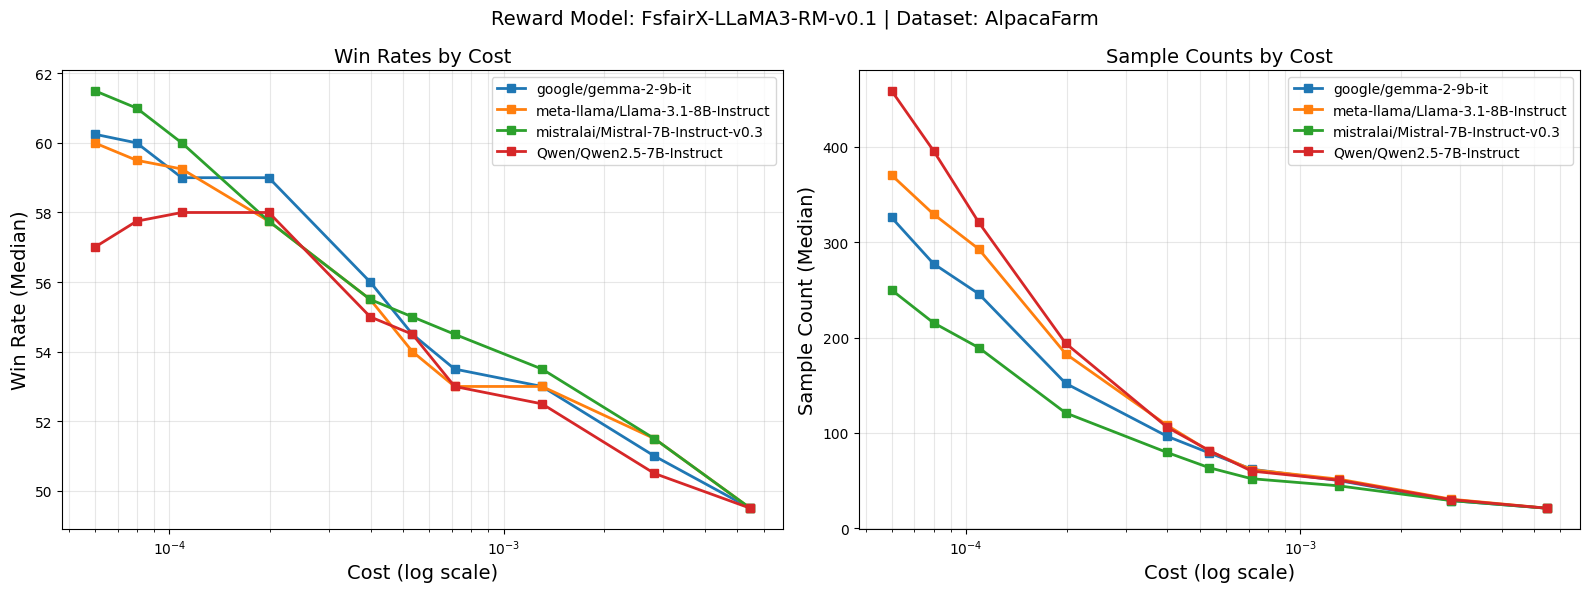

In [38]:

data_points_all = {}
rm_name = rms[0]
for llm_name in [llms[0], llms[1], llms[3], llms[4]]:
# for llm_name in [llms[0]]:
    print(llm_name, flush=True)
    out = get_sample_vs_winrate(llm_name, rm_name)
    data_points_all[llm_name] = out

# out = plot_win_rate_analysis(data_points_all, rm_name = "")
# print(out)
# figures[f"sample_count-{rm_name}"] = out[0]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# fig.suptitle('Pandora\'s Box vs Best of N: Win Rate Analysis (Mistral-7B-RM)', fontsize=16, fontweight='bold')
plot_title = "Reward Model: FsfairX-LLaMA3-RM-v0.1 | Dataset: AlpacaFarm"
fig.suptitle(plot_title, fontsize=14)
# ax1 = axes[0]
_ = plot_win_rate_analysis_by_cost_multi(axes[1], data_points_all, 0, show_plot=False, title="Sample Counts by Cost", xlabel="Cost (log scale)", ylabel="Sample Count (Median)")
_ = plot_win_rate_analysis_by_cost_multi(axes[0], data_points_all, 1, show_plot=False, title="Win Rates by Cost", xlabel="Cost (log scale)", ylabel="Win Rate (Median)")

plt.show()

In [ ]:
data_points_all = {}
rm_name = rms[0]
for llm_name in [llms[0], llms[1], llms[3], llms[4]]:
# for llm_name in [llms[0]]:
    print(llm_name, flush=True)
    out = get_sample_vs_winrate(llm_name, rm_name)
    data_points_all[llm_name] = out

# out = plot_win_rate_analysis(data_points_all, rm_name = "")
# print(out)
# figures[f"sample_count-{rm_name}"] = out[0]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# fig.suptitle('Pandora\'s Box vs Best of N: Win Rate Analysis (Mistral-7B-RM)', fontsize=16, fontweight='bold')
plot_title = "Reward Model: FsfairX-LLaMA3-RM-v0.1 | Dataset: AlpacaFarm"
fig.suptitle(plot_title, fontsize=14)
# ax1 = axes[0]
_ = plot_win_rate_analysis_by_cost_multi_with_percentiles(axes[1], data_points_all, 0, show_plot=False, title="Sample Counts by Cost", xlabel="Cost (log scale)", ylabel="Sample Count (Median)")
_ = plot_win_rate_analysis_by_cost_multi_with_percentiles(axes[0], data_points_all, 1, show_plot=False, title="Win Rates by Cost", xlabel="Cost (log scale)", ylabel="Win Rate (Median)")

plt.show()